# Collecting and Analyzing Tweets

To replicate my set up and run this notebook, please visit https://github.com/galletti94/Tweet-Monitor

## Exploratory Data Analysis

I love exploring data! As you will see, taking the time to explore the data and develop some intuition about what we have collected will make us much more producive during the analysis and modeling phase. We will be able to quickly understand why some models fail and identify what next steps should be taken. Let's get started!

### Let's get some tweets!

For this step we use the twitter API which requires you to have a twitter account. Twitter gives you access keys which are unique to your account. These keys will go in a file called keys.txt which we make sure to include in the .gitignore file so that these are not made publically available. Let's get started!

In [1]:
import tweepy
import json
from pymongo import MongoClient
from __future__ import print_function

MONGO_HOST = 'mongodb://localhost/usa_db'

LOCATION = [-127.3,24.1,-65.9,51.8]

# get credentials from the keys.txt file
keys_file = open("keys.txt")
lines = keys_file.readlines()
consumer_key = lines[0].rstrip()
consumer_secret = lines[1].rstrip()
access_token = lines[2].rstrip()
access_token_secret = lines[3].rstrip()
keys_file.close()

class StreamListener(tweepy.StreamListener):
    # This is a class provided by tweepy to access the Twitter Streaming API.

    def on_connect(self):
        # Called initially to connect to the Streaming API
        print("You are now connected to the streaming API.")

    def on_error(self, status_code):
        print('An Error has occured: ' + repr(status_code))
        return False

    def on_data(self, data):
        try:
            client = MongoClient(MONGO_HOST)
            db = client.usa_db
            
            datajson = json.loads(data) # Decode the JSON from Twitter

            # grab the 'created_at' data from the Tweet to use for display
            created_at = datajson['created_at']
            
            # only get tweets that have geo location enabled
            if datajson['coordinates']:
                # print out a message to the screen that we have collected a tweet
                print("Tweet collected at " + str(created_at))
                db.usa_tweets_collection.insert_one(datajson) #insert into db
                
        except Exception as e:
            print(e)


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
listener = StreamListener(api=tweepy.API(wait_on_rate_limit=True))
streamer = tweepy.Stream(auth=auth, listener=listener)

print("Tracking: " + 'United States')
streamer.filter(locations=LOCATION)

Tracking: United States


Awesome - now we can let this run and collect some tweets!

After waiting a few minutes for your database to fill up, you can hit CTRL + C to stop the collection and stop the program.

### What do we have here?

Let's take a look at the tweets we collected!

### Where in the US are these tweets coming from?

We can use folium to map the coordinates of the tweets on a map:

In [2]:
from pymongo import MongoClient
import folium

client = MongoClient('localhost', 27017)
db = client['usa_db']
collection = db['usa_tweets_collection']
tweets_iterator = collection.find()

mymap = folium.Map(location=[39.50, -98.35], zoom_start=4)
i = 0
for tweet in tweets_iterator:
    # only look at 1/8th of tweets because there are so many tweets
    if i % 8 == 0 and tweet['coordinates']:
        folium.CircleMarker(location=list(reversed(tweet['coordinates']['coordinates'])), radius=2).add_to(mymap)
    i +=1
    
mymap.save('map.html')
display(mymap)

Nice. Zoom in and check out how popular tweeting is in your state!

Let's now look at what kinds of emojis people use!

### Emojis


In [3]:
from emoji import UNICODE_EMOJI

tweets_iterator = collection.find()

d = dict()

for tweet in tweets_iterator:
  for ch in list(tweet['text']):  #remember emojis are characters not words
    if ch in UNICODE_EMOJI:
      try:
        d[ch] += 1
      except KeyError:
        d[ch] = 1

d = sorted(d.items(), key=lambda x: -x[1])
print(d[:15])

[('😂', 229), ('❤', 195), ('🔥', 189), ('😍', 149), ('🏾', 142), ('🏼', 134), ('🎄', 126), ('🏽', 121), ('🏻', 111), ('😭', 100), ('❄', 97), ('✨', 83), ('🙌', 80), ('♀', 78), ('💯', 75)]


When this was written it was close to christmas so the christmas tree and snow flakes emojis make sense.

Let's put these emojis on the map so that we can view the popular emojis per state!

### Mapping Emojis

First we need to find the popular emojis per state

In [4]:
from emoji import UNICODE_EMOJI
import re

USA = ['Alabama','AL','Montana','MT','Alaska','AK','Nebraska','NE','Arizona','AZ','Nevada','NV','Arkansas',
       'AR','New Hampshire','NH','California','CA','New Jersey','NJ','Colorado','CO','New Mexico','NM',
       'Connecticut','CT','New York','NY','Delaware','DE','North Carolina','NC','Florida','FL','North Dakota',
       'ND','Georgia','GA','Ohio','OH','Hawaii','HI','Oklahoma','OK','Idaho','ID','Oregon','OR','Illinois','IL',
       'Pennsylvania','PA','Indiana','IN','Rhode Island','RI','Iowa','IA','South Carolina','SC','Kansas','KS',
       'South Dakota','SD','Kentucky','KY','Tennessee','TN','Louisiana','LA','Texas','TX','Maine','ME','Utah','UT',
       'Maryland','MD','Vermont','VT','Massachusetts','MA','Virginia','VA','Michigan','MI','Washington','WA',
       'Minnesota','MN','West Virginia','WV','Mississippi','MS','Wisconsin','WI','Missouri','MO','Wyoming','WY']

the_states = list(map(lambda x : x.lower(), USA))

tweets_iterator = collection.find()

#counts the occurence of every emoji per state, sorts by occurrence and returns the emojis
def count(mylist):
    d = dict()
    for item in mylist:
        try:
            d[item] += 1
        except:
            d[item] = 1
    d = sorted(d.items(), key=lambda x: -x[1])
    return [x[0] for x in d]


#get top 2 emojis per state
d1 = dict()
d2 = dict()
for tweet in tweets_iterator:
    if tweet['user']['location'] and ',' in tweet['user']['location']:
        for ch in list(tweet['text']):
            if ch in UNICODE_EMOJI:
                #extract the state from the user address
                state = re.sub(' ', '', tweet['user']['location'].split(',')[1]).lower()
                #make sure location is enabled and the state is a US state
                if tweet['coordinates'] and state in the_states: 
                    try:
                        d2[state][ch] = tweet['coordinates']['coordinates']
                    except:
                        d2[state] = {ch :  tweet['coordinates']['coordinates']}
                    # get all emojis per state
                    try:
                        d1[state].append(ch)
                    except:
                        d1[state] = [ch]

#get top 2 emojis per state
for key in d1:
    d1[key] = count(d1[key])[:2]
    
print(d1)

{'oh': ['😏', '🍩'], 'wisconsin': ['🌞'], 'mt': ['\U0001f923', '❤'], 'nj': ['🔥', '😘'], 'or': ['😍', '😉'], 'texas': ['💯', '❤'], 'tennessee': ['🐾', '❤'], 'illinois': ['🎄', '🎁'], 'colorado': ['☀', '📸'], 'nd': ['🎁', '🏻'], 'ct': ['👁', '💪'], 'fl': ['🏾', '💪'], 'sc': ['😍', '🍷'], 'va': ['👧', '👩'], 'ga': ['💪', '🔥'], 'az': ['🌹', '😍'], 'arkansas': ['👏', '⏳'], 'wy': ['😊', '💥'], 'tn': ['✨', '❤'], 'indiana': ['💗'], 'ms': ['\U0001f919', '☕'], 'oklahoma': ['😂', '🦄'], 'washington': ['❣'], 'mn': ['💛', '🔷'], 'georgia': ['🏾', '✊'], 'ar': ['👀', '💈'], 'oregon': ['❄'], 'nc': ['🎄', '🏾'], 'ia': ['🏽', '🤘'], 'virginia': ['✨'], 'ne': ['☃', '🏻'], 'florida': ['💞', '💕'], 'co': ['💦', '🌳'], 'de': ['❤'], 'hi': ['🎣', '♂'], 'ky': ['🏼', '👌'], 'wv': ['🍩', '⚡'], 'tx': ['🚨', '‼'], 'mi': ['💯', '🏽'], 'pa': ['❗', '☕'], 'ma': ['🙌', '☕'], 'maine': ['😓', '\U0001f5a4'], 'pennsylvania': ['🌧'], 'in': ['⚡', '😍'], 'alabama': ['💗', '\U0001f5a4'], 'mississippi': ['🍂', '🍃'], 'md': ['♂', '❤'], 'mo': ['🌊', '😍'], 'ks': ['🎉'], 'nevada': ['💯', '✨']

Great! Now that we have the top emojis per state and have recorded some coordinates in each state, we can put these emojis on the map to see the top emojis per state!

Folium has a custom marker method that allows you to create your own marker instead of using built-in ones such as the circles we used above. The problem is this method only accepts images or urls of images. We will need to search online to find links to these images and we will want to automate this process because of the quantity of emojis we have. We need to do a bit of web crawling! I will only post an outline of this code here but the idea is that we will end up with a dictionary of links to emoji images - never downloading any of these images. We can then use this dictionary to generate the custom markers and create the map!

In [5]:
from emoji import UNICODE_EMOJI, emojize
import urllib.request
from selenium import webdriver
d_links = dict()

for key in d1:
    for emo0 in d1[key]:
        #print(emo0)
        if emo0 in d_links:
            continue
        else:
            try:
                site = '/website/containing/searchable/emoji/images'+ emojize(emo0)
                browser = webdriver.Chrome('./chromedriver')
                browser.get(site)
                html_source = browser.page_source
                links = re.findall('look/in/source/page/for/link/to/emoji/image.+.png', html_source)
                link = links[0]
                #print('link to image = ', link)
                d_links[emo0] = link
            except Exception as e:
                continue

#print(d_links)

In [6]:
import folium

mymap = folium.Map(location=[39.50, -98.35], zoom_start=4)

for key in d1:
    for emo0 in d1[key]:
        try:
            link = d_links[emo0]
        except KeyError:
            #print('error')
            continue
        icon_url = folium.features.CustomIcon(link)
        coord = d2[key][emo0]
        #print(coord)
        folium.Marker(location=list(reversed(coord)), icon=icon_url).add_to(mymap)

mymap.save('emojiMap.html')
display(mymap)

Neat. Try to find what emojis are most popular in your state!

Emojis are great because we can quickly visually see the what a tweet conveys without having to read the entire tweet. However this may not be as accurate because emojis are used for many reasons. So we do need to look at text as well to get the full scope.

### Sentiment Analysis


We can analyze the words of the tweets to get a sense of whether the tweet has positive sentiment or negative sentiment. We can aggregate these and get a sense of the general mood of the US at this time of year.

In [7]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

tweets_iterator = collection.find()

tweetCnt = 0
locEnabled = 0
d = dict()
only1000 = 1000

for tweet in tweets_iterator:
    if only1000 <= 0:
        break
    tweetCnt += 1
    if tweet['coordinates']:
        locEnabled += 1
    blob = TextBlob(tweet['text'], analyzer=NaiveBayesAnalyzer())
    try:
        d[blob.sentiment.classification] += 1
    except KeyError:
        d[blob.sentiment.classification] = 1
    only1000 -= 1

d = sorted(d.items(), key=lambda x: -x[1])
print(d)
print()
print('Number of Tweets = ', tweetCnt)
print()
print('Number of tweets with location enabled = ', locEnabled)

[('pos', 625), ('neg', 375)]

Number of Tweets =  1000

Number of tweets with location enabled =  212


Seems like a majority of tweets have positive sentiment but this analysis was only conducted on a subset of the data collected since sentiment analysis is expensive to compute.

Maybe next we can see which emojis are correlated with which sentiment!

### Emoji vs Sentiment


In [3]:
tweets_iterator = collection.find()

pos_dict = dict()
neg_dict = dict()
only200 = 200
for tweet in tweets_iterator:
    if only200 <= 0:
        break
    for ch in list(tweet['text']):
        if ch in UNICODE_EMOJI:
            only200 -= 1
            blob = TextBlob(tweet['text'], analyzer=NaiveBayesAnalyzer())
            if blob.sentiment.classification == 'pos':
                try:
                    pos_dict[ch] += 1
                except KeyError:
                    pos_dict[ch] = 1
            else:
                try:
                    neg_dict[ch] += 1
                except KeyError:
                    neg_dict[ch] = 1

pos_dict = sorted(pos_dict.items(), key=lambda x: -x[1])
neg_dict = sorted(neg_dict.items(), key=lambda x: -x[1])                    
print('positive emojis = ', pos_dict[:5])
print()
print('negative_emojis = ', neg_dict[:5])

positive emojis =  [('🌹', 9), ('❤', 9), ('✨', 8), ('🎄', 6), ('🎶', 6)]

negative_emojis =  [('😭', 7), ('🔥', 6), ('💦', 4), ('❣', 2), ('⛓', 2)]


Great! It seems intuitive that a rose, a heart, and stars be associated with positive sentiment and a crying face would be associated with negative sentiment. It is good to see these results support our intuition!

Now we would like to know what kinds of tweets do people with location disabled make?

### Location Disabled Tweets - Emojis

First let's look at the kinds of emojis are used in both groups.

In [8]:
tweets_iterator = collection.find()

enabled_dict = dict()
disabled_dict = dict()
tweetcnt = 0
for tweet in tweets_iterator:
    tweetcnt += 1
    for ch in list(tweet['text']):
        if ch in UNICODE_EMOJI:
            if tweet['coordinates']:
                try:
                    enabled_dict[ch] += 1
                except KeyError:
                    enabled_dict[ch] = 1
            else:
                try:
                    disabled_dict[ch] += 1
                except KeyError:
                    disabled_dict[ch] = 1

enabled_dict = sorted(enabled_dict.items(), key=lambda x: -x[1])
disabled_dict = sorted(disabled_dict.items(), key=lambda x: -x[1])
print('Number of Tweets = ', tweetcnt)
print()
print('location enabled emojis = ', enabled_dict[:10])
print()
print('location disabled emojis = ', disabled_dict[:10])

Number of Tweets =  23226

location enabled emojis =  [('❤', 169), ('🔥', 164), ('🎄', 124), ('😍', 122), ('🏼', 115), ('🏾', 114), ('😂', 104), ('🏻', 95), ('🏽', 93), ('✨', 81)]

location disabled emojis =  [('😂', 125), ('😭', 81), ('🏾', 28), ('♀', 28), ('🏽', 28), ('😍', 27), ('\U0001f926', 26), ('❤', 26), ('❄', 25), ('🔥', 25)]


Looks like people with location enabled use, in majority, emojis that we evaluated earlier to be positive sentiment!

I wonder if there is a difference in what topics these two groups post about. Let's look at the tags in their tweets to get a sense of what these people post about!

### Location Disabled Tweets - Tags

In [9]:
import re

tweets_iterator = collection.find()

enabled_dict = dict()
disabled_dict = dict()
tweetcnt = 0
for tweet in tweets_iterator:
    tweetcnt += 1
    for tag in re.findall(r'\B(\#[a-zA-Z]+\b)(?!;)', tweet['text']):
        if tweet['coordinates']:
            try:
                enabled_dict[tag] += 1
            except KeyError:
                enabled_dict[tag] = 1
        else:
            try:
                disabled_dict[tag] += 1
            except KeyError:
                disabled_dict[tag] = 1

enabled_dict = sorted(enabled_dict.items(), key=lambda x: -x[1])
disabled_dict = sorted(disabled_dict.items(), key=lambda x: -x[1])
print('Number of Tweets = ', tweetcnt)
print()
print('location enabled tags = ', enabled_dict[:10])
print()
print('location disabled tags = ', disabled_dict[:10])

Number of Tweets =  23226

location enabled tags =  [('#job', 7322), ('#CareerArc', 6157), ('#Hiring', 5750), ('#hiring', 2842), ('#Jobs', 1996), ('#Job', 1995), ('#Retail', 1040), ('#Hospitality', 750), ('#Sales', 460), ('#Nursing', 433)]

location disabled tags =  [('#netneutrality', 2), ('#ImpeachTrump', 2), ('#PokemonGO', 2), ('#TheResistance', 2), ('#snow', 2), ('#Californie', 1), ('#parents', 1), ('#Murrieta', 1), ('#uscf', 1), ('#Ohtani', 1)]


It looks like tweets with location disabled don't contain many tags. I will let you make your own conclusions about the content type...

To get a better idea of what topics people with location enables and disabled tweet about, we can turn the problem around. Let's start from a specific set of keywords and observe the distribution of location enabled vs disabled!

### Keywords about Machine Learning

In [10]:
from __future__ import print_function
import tweepy
import json
from pymongo import MongoClient

MONGO_HOST = 'mongodb://localhost/twitterdb'

WORDS = ['#deeplearning', '#computervision', '#datascience', '#bigdata']

keys_file = open("keys.txt")
lines = keys_file.readlines()
consumer_key = lines[0].rstrip()
consumer_secret = lines[1].rstrip()
access_token = lines[2].rstrip()
access_token_secret = lines[3].rstrip()

class StreamListener(tweepy.StreamListener):
    def on_connect(self):
        print("You are now connected to the streaming API.")

    def on_error(self, status_code):
        print('An Error has occured: ' + repr(status_code))
        return False

    def on_data(self, data):
        # This is the meat of the script...it connects to your mongoDB and stores the tweet
        try:
            client = MongoClient(MONGO_HOST)
            db = client.twitterdb
            datajson = json.loads(data)
            created_at = datajson['created_at']
            print("Tweet collected at " + str(created_at))
            db.twitter_search.insert(datajson)
        except Exception as e:
            print(e)

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
listener = StreamListener(api=tweepy.API(wait_on_rate_limit=True))
streamer = tweepy.Stream(auth=auth, listener=listener)

print("Tracking: " + str(WORDS))
streamer.filter(track=WORDS)

Tracking: ['#deeplearning', '#computervision', '#datascience', '#bigdata']


As before, keep this runnning for a short while in order to collect some tweets.

Let's keep exploring!

### Location of ML people

In [11]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['twitterdb']
collection = db['twitter_search']
tweets_iterator = collection.find()

d = dict()
enabled = 0
disabled = 0
tweetcnt = 0
for tweet in tweets_iterator:
    tweetcnt += 1
    
    for ch in list(tweet['text']):  #remember emojis are characters not words
        if ch in UNICODE_EMOJI:
          try:
            d[ch] += 1
          except KeyError:
            d[ch] = 1
    
    if tweet['coordinates']:
        enabled += 1
    else:
        disabled += 1

d = sorted(d.items(), key=lambda x: -x[1])
print('Total Tweets = ', tweetcnt)
print('location enabled = ', enabled)
print('location disabled = ', disabled)
print('emojis = ', d)

Total Tweets =  1019
location enabled =  0
location disabled =  1019
emojis =  [('🗣', 20), ('👏', 8), ('👉', 6), ('▶', 1), ('🚨', 1), ('📣', 1), ('📈', 1), ('📢', 1), ('🐸', 1), ('®', 1), ('👀', 1), ('🏽', 1), ('™', 1), ('📦', 1), ('🌐', 1)]


Looks like people who post about these keywords don't share their location! Interesting emojis as well! At this point, we can try other combinations of words that we have intuition for whether location should be enabled or disabled. But we will not do this here and instead we will keep exploring more broadly.

### Source of Tweets

Going back to USA tweets, we can analyze the source of the tweet to understand what people post about on which device for example. We can also look at whether a person's location is more likely to be enabled or disabled depending on the device they use.

Let's first take a look at the distribution of devices.

In [12]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['usa_db']
collection = db['usa_tweets_collection']
tweets_iterator = collection.find()

d = dict()
for tweet in tweets_iterator:
    s = ''.join(tweet['source'].split('>')[1].split('<')[0])
    if s:
        try:
            d[s] += 1
        except KeyError:
            d[s] = 1

d = sorted(d.items(), key=lambda x: -x[1])
print(d[:10])

[('TweetMyJOBS', 9585), ('Instagram', 6765), ('Twitter for iPhone', 1387), ('Foursquare', 881), ('SafeTweet by TweetMyJOBS', 665), ('NYRegions', 392), ('Cities', 360), ('Twitter for Android', 324), ('TownTweet', 300), ('Untappd', 140)]


Now we can map some of these devices (if location is enabled) and start developing intuition about which devices are more prone to enable location. Let's start mapping!

### Map of devices

In [16]:
tweets_iterator = collection.find()

mymap = folium.Map(location=[39.50, -98.35], zoom_start=4)

i = 0
for tweet in tweets_iterator:
    if ''.join(tweet['source'].split('>')[1].split('<')[0]) == 'Instagram' and tweet['coordinates']:
        if i %3 == 0:
            folium.CircleMarker(location=list(reversed(tweet['coordinates']['coordinates'])), radius=2).add_to(mymap)
        i += 1
    
mymap.save('map3.html')
display(mymap)

It is interesting to note that many people who use this feature have their location enabled. If we now plot the tweets made on the Twitter App for iPhone, the results are drastically different:

In [17]:
tweets_iterator = collection.find()

mymap = folium.Map(location=[39.50, -98.35], zoom_start=4)

for tweet in tweets_iterator:
    if (''.join(tweet['source'].split('>')[1].split('<')[0]) == 'Twitter for iPhone' 
        or ''.join(tweet['source'].split('>')[1].split('<')[0]) == 'Twitter for Android') and tweet['coordinates']:
        
        folium.CircleMarker(location=list(reversed(tweet['coordinates']['coordinates'])), radius=2).add_to(mymap)
    
mymap.save('map4.html')
display(mymap)

But Instagram is also an application available on smart phones like Android and iPhone. Are your location settings application dependent? That is, if you share an instagram post on twitter, is your location setting that of instagram or that of twitter? And does this vary per device? Someone should test this out!

Now that we have explored the tweets we have collected and gained some intuition about what people tweet, where, how, and why, we can try and solve a concrete problem. I am particularly interested in seeing whether it is possible to predict if someone's location is enabled or disabled based on the emojis they use. Let's find out!


## Learning

First we create a table where the columns are emojis and the rows are specific tweets. An element of this table will be 1 if the tweet contains the emoji of the given column and 0 otherwise. (Note: A different approach could be to have the elements represent the frequency with which each emoji appears in a given tweet). We can then do some linear algebra to see which combinations of emojis contribute the most to the information of the table.

### SVD

In [6]:
import pandas as pd
from emoji import UNICODE_EMOJI

all_emojis = []
for tweet in tweets_iterator:
  for ch in list(tweet['text']):
    if ch in UNICODE_EMOJI and ch not in all_emojis:
      all_emojis.append(ch)

d = dict([x, []] for x in all_emojis)
res = pd.DataFrame.from_dict(data=d)

tweets_iterator = collection.find()
for emo in list(res.columns):
  i = 20000      #This is to limit the amount of tweets we store in our table
  emoji_presence = []
  tweets_iterator = collection.find()
  for tweet in tweets_iterator:
    if i <= 1000:   #Only get the last 4000 or so tweets
      if str(emo) in tweet['text']:
        emoji_presence.append(1)
      else:
        emoji_presence.append(0)
    i -= 1
  res.loc[:,emo] = emoji_presence

res.to_csv('./emojis.csv', index = False)
check = pd.read_csv('./emojis.csv')

Success! We created the table and stored it into a file so that we don't have to do this computation again. We only took a subset of tweets (about 4000) so that we can get a general idea relatively quickly and not waste time running our code for 3 days. Now that we have this subset of data, we can study this table. We will decompose the table into singular vectors and singular values which represent combinations of emojis and more or less how much information they bring to the table (pun intended). You can read more about SVD [here](https://en.wikipedia.org/wiki/Singular-value_decomposition)

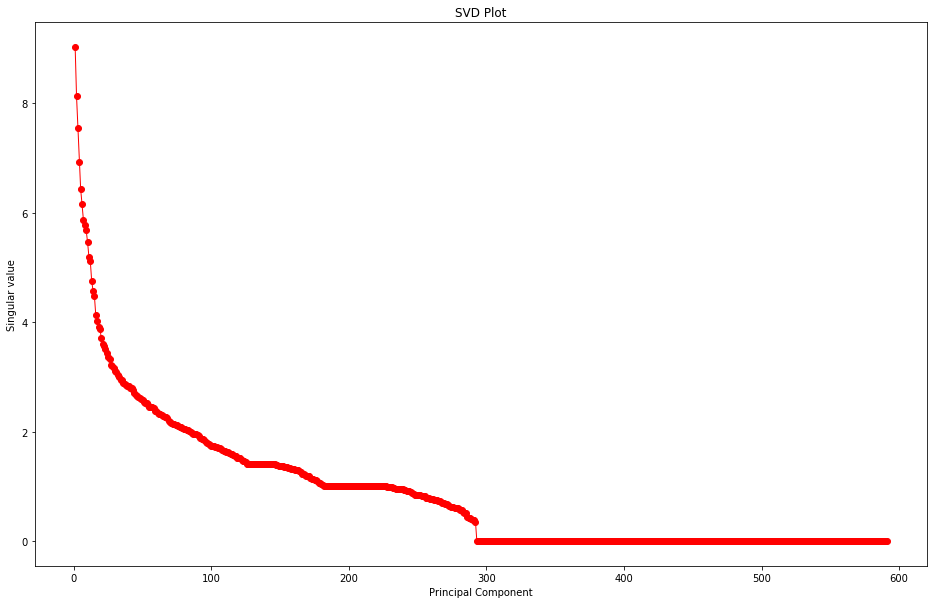

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('emojis.csv')
num_vars = len(df.columns)
num_obs = len(df.iloc[:,0])

A = df.as_matrix()

U, S, V = np.linalg.svd(A)  #sv decompostion

fig = plt.figure(figsize=(16,10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, S, 'ro-', linewidth=1)
plt.title('SVD Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular value')
plt.show()

Originally we were working with about 600 emojis i.e the space in which we were working was 600 dimensional! By the power of math were able to reduce the problem considerably. If you look at the plot above, it is saying that we really only need 100 or so dimension to capture most of what was in our 600 dimensional space. This is great news! Let's extract only the first 100 singular vectors and try to implement a 3 layer Neural Network!

### Neural Network

In [4]:
from sklearn.decomposition import PCA as sklearnPCA
tweets_iterator = collection.find()

# Get the Y vector of location enabled/disabled
i = 20000
location = []
for tweet in tweets_iterator:
  if i <= 1000:   
    if tweet['coordinates']:
      location.append(1)
    else:
      location.append(0)
  i-=1

#Extract the first 100 principal components
sklearn_pca = sklearnPCA(n_components=100)
X = sklearn_pca.fit_transform(A)
Y = np.array(location).reshape(4226, 1)

def sig(x):
    return 1/(1 + np.exp(-x))

def sigDiv(x):
    return np.exp(x)*(1-np.exp(x))

def NN3_sig(X, Y, stopWhen):
    print("--- Using activation function sig ---")
    print()
    colsize = len(list(X[1]))
    rowsize = len(list(X[:, 1]))
    
    w0 = 2*np.random.random((colsize, colsize)) - 1
    w1 = 2*np.random.random((colsize, rowsize)) - 1
    w2 = 2*np.random.random((rowsize, 1)) - 1
    err = []
    
    while stopWhen >= 0:
        stopWhen -= 1
        l0 = X
        l1 = sig(np.dot(l0, w0)) 
        l2 = sig(np.dot(l1, w1))
        l3 = sig(np.dot(l2, w2))

        l3_error = Y - l3
        
        l3_delta = l3_error * sigDiv(l3)
        l2_error = l3_delta.dot(w2.T)
        l2_delta = l2_error * sigDiv(l2)
        l1_error = l2_delta.dot(w1.T)
        l1_delta = l1_error * sigDiv(l1)
        
        err.append(np.mean(l3_error))
        
        if len(err) %10 == 0:
            print(err[-1])

        w0 += l0.T.dot(l1_delta)
        w1 += l1.T.dot(l2_delta)
        w2 += l2.T.dot(l3_delta)

    print("Predictions made after training: ")
    print()
    print(l3)
    print()
    print("How good are these predictions?")
    print()
    print(np.mean(l3_error))
    #return [w0, w1, w2]

np.random.seed(123)
NN3_sig(X, Y, 100)

--- Using activation function sig ---



/home/alexander/Documents/SQL/MongoDB/Tweet-monitoring-app/tweetEnv/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


0.0747412619464
0.0748252374789
0.0748033625898
0.0747394471336
0.074742047879
0.0747621294683
0.074683939739
0.0747049338653
0.0747229942236
0.0747388184191
Predictions made after training: 

[[ 0.5]
 [ 1. ]
 [ 0.5]
 ..., 
 [ 0.5]
 [ 0.5]
 [ 0.5]]

How good are these predictions?

0.0747402879282


Interesting. Seems like predicting location from emojis using this particular Neural Network did not give great results - good thing we didn't gamble with the entire dataset! Their are many other types of Neural Networks we could try but for the sake of exploration, let's try a different approach.

Notice that this problem is essentially a separation problem, i.e. can we separate the space of emojis such that one side has location enabled and the other has location disabled? Let's try Support Vector Machines (SVMs)!

### SVM

For visualization sake, we will only use the first 2 singular vectors we found above.

Text(0.5,1,'SVM Fit Plot')

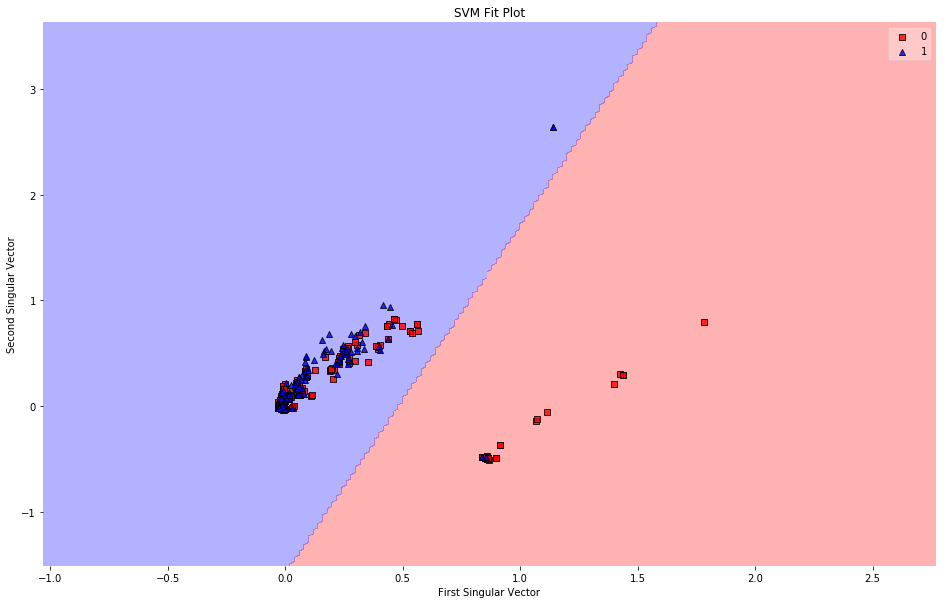

In [37]:
%matplotlib inline

from sklearn import svm
from mlxtend.plotting import plot_decision_regions

sklearn_pca = sklearnPCA(n_components=2)
X = sklearn_pca.fit_transform(A)

Y = np.array(location)
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)

fig = plt.figure(figsize=(16,10))
plot_decision_regions(X=X, y=Y, clf=clf)
plt.xlabel('First Singular Vector')
plt.ylabel('Second Singular Vector')
plt.title('SVM Fit Plot')

Look at that! This plot shows us that one of the reasons our models are having a hard time is because of that very cluttered region. Also maybe a linear separator is not the best idea. Let's try fitting something more flexible than a line:

Text(0.5,1,'SVM Fit Plot')

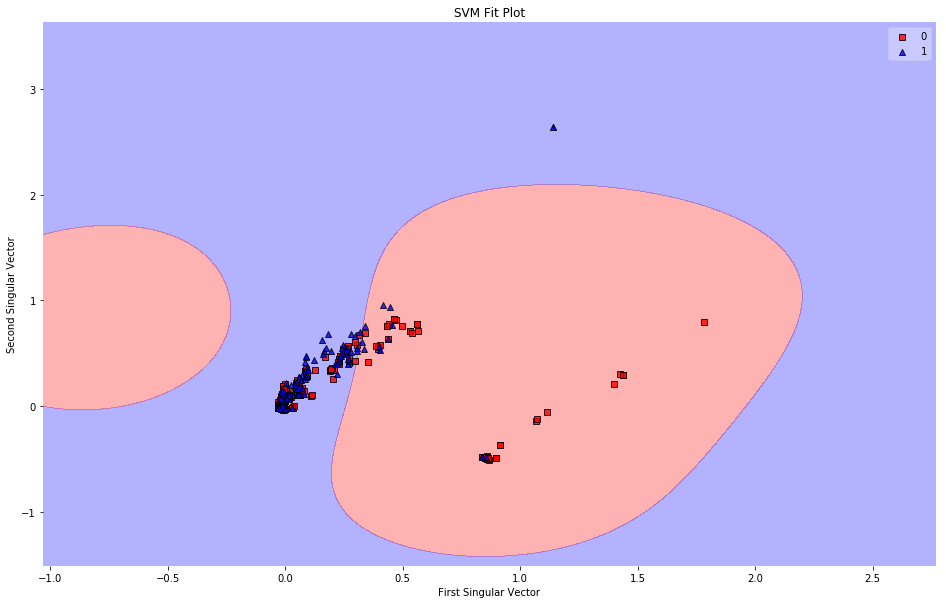

In [38]:
%matplotlib inline

clf = svm.SVR()
clf.fit(X, Y)

fig = plt.figure(figsize=(16,10))
plot_decision_regions(X=X, y=Y, clf=clf)
plt.xlabel('First Singular Vector')
plt.ylabel('Second Singular Vector')
plt.title('SVM Fit Plot')

Looks better! In practice we would use more of those singular vectors and tranform the data to avoid that cluttered region around 0. There is so much more to be done and explored! I hope this post inspires you to try out some of your ideas. Feel free to reach out if you have any comments or questions!


-- Lance Galletti